In [1]:
## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()


import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torch.optim as optim
import os
import random
import pickle
import torchvision
import shutil
from torchvision import transforms
from tqdm import tqdm

C:\Users\PC\AppData\Local\Temp\ipykernel_4552\2949133806.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [2]:
torch.cuda.set_device(0)
device = torch.device("cuda")

def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_all_seeds(42)

# Read data

## Create val folder

In [3]:
def check_classes_amounts(path):
    classes = os.listdir(path)
    num_all = 0
    num_class = []
    for i in range(len(classes)):
        num_of_class = len(os.listdir(f"{path}/{classes[i]}"))
        num_class.append(num_of_class)
        num_all += num_of_class
    print(f"Number of all examples: {num_all}\nNumbers of every class: {num_class}")
    # return num_all, num_class

In [4]:
check_classes_amounts("./trafic_32")

Number of all examples: 31368
Numbers of every class: [168, 1776, 1800, 1128, 1584, 1488, 336, 1152, 1128, 1176, 1608, 1056, 1680, 1728, 624, 504, 336, 888, 960, 168, 288, 264, 312, 408, 216, 1200, 480, 192, 432, 216, 360, 624, 192, 552, 336, 960, 312, 168, 1656, 240, 288, 192, 192]


In [5]:
def create_val_folder():
    sub_folders = os.listdir("./trafic_32")
    os.mkdir("./val_trafic_32")
    for sub_folder in sub_folders:
        os.mkdir(f"./val_trafic_32/{sub_folder}")

    for sub_folder in sub_folders:
        images_list = os.listdir(f"./trafic_32/{sub_folder}")
        to_move = random.sample(images_list, k=(len(images_list) // 5))
        for image in to_move:
            shutil.move(f"./trafic_32/{sub_folder}/{image}", f"./val_trafic_32/{sub_folder}/{image}")


In [6]:
# create_val_folder()

In [7]:
check_classes_amounts("./trafic_32")

Number of all examples: 31368
Numbers of every class: [168, 1776, 1800, 1128, 1584, 1488, 336, 1152, 1128, 1176, 1608, 1056, 1680, 1728, 624, 504, 336, 888, 960, 168, 288, 264, 312, 408, 216, 1200, 480, 192, 432, 216, 360, 624, 192, 552, 336, 960, 312, 168, 1656, 240, 288, 192, 192]


In [8]:
check_classes_amounts("./val_trafic_32")

Number of all examples: 7841
Numbers of every class: [42, 444, 450, 282, 396, 372, 84, 288, 282, 294, 402, 264, 420, 432, 156, 126, 84, 222, 240, 42, 72, 66, 78, 102, 54, 300, 120, 48, 108, 54, 90, 156, 48, 137, 84, 240, 78, 42, 414, 60, 72, 48, 48]


## Data preparation

In [9]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.ImageFolder("trafic_32/", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)


val_dataset = datasets.ImageFolder("val_trafic_32/", transform=transform)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, drop_last=False, num_workers=4)

In [10]:
# does not work after transfation from image format to tensor
# from IPython.display import display
#
# image_num = 31367
# scale = 4
# display(train_dataset[image_num][0].resize(( int(train_dataset[image_num][0].width * scale), int(train_dataset[image_num][0].height * scale))))

# Net preparation

In [11]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean  = nn.Linear(hidden_dim, latent_dim)
        self.fc_var   = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        x = torch.flatten(x, 1)
        x       = self.LeakyReLU(self.fc_1(x))
        x       = self.LeakyReLU(self.fc_2(x))
        mean     = self.fc_mean(x)
        log_var  = self.fc_var(x)

        return mean, log_var

In [12]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))

        x_hat = torch.sigmoid(self.fc_3(h))
        # x_hat = x_hat.view([-1, 1, 28, 28])
        x_hat = x_hat.view([-1, 3, 32, 32])
        return x_hat


In [13]:
class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)


    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)        # sampling epsilon
        z = mean + var * epsilon
        return z


    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

In [14]:
def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD      = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [15]:
vae = VAE(latent_dim=256, hidden_dim=1024, x_dim=3072).to(device)

In [16]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [17]:
# num_epochs = 30
# for n in range(num_epochs):
#     losses_epoch = []
#     for x, _ in tqdm(iter(train_loader)):
#         x = x.to(device)
#         out, means, log_var = vae(x)
#         loss = vae_loss_function(x, out, means, log_var)
#         losses_epoch.append(loss.item())
#         loss.backward()               # backward pass (compute parameter updates)
#         optimizer.step()              # make the updates for each parameter
#         optimizer.zero_grad()
#     L1_list = []
#     if n == 0 or n == 29:
#         for x, _ in iter(val_loader):
#             x  = x.to(device)
#             out, _, _ = vae(x)
#             L1_list.append(torch.mean(torch.abs(out-x)).item())
#         print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
#     scheduler.step()

In [18]:
def get_train_images(start, num):
    return torch.stack([val_dataset[i][0] for i in range(start,start+num)], dim=0)

In [19]:
def visualize_reconstructions(model, input_imgs, device):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs, means, log_var = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=False, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [20]:
# input_imgs = get_train_images(6765, 8)
# visualize_reconstructions(vae, input_imgs, device)

In [21]:
def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    with torch.no_grad():
        generated_imgs = model.decoder(torch.randn([n_imgs, model.latent_dim]).to(device))
    generated_imgs = generated_imgs.cpu()

    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=False, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [22]:
generate_images(vae, 16 , device)

NameError: name 'input_imgs' is not defined

# Model GAN (Generative Adversarial Networks)

In [23]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out  = nn.Linear(hidden_dim, 1)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        x = self.fc_out(x)
        return x

In [24]:
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))

        x_hat = torch.sigmoid(self.fc_3(h))
        # x_hat = x_hat.view([-1, 1, 28, 28])
        x_hat = x_hat.view([-1, 3, 32, 32])
        return x_hat

In [59]:
# Models
latent_dim = 128
generator = Generator(latent_dim=latent_dim, hidden_dim=1024, output_dim=3072).to(device)
discriminator = Discriminator( hidden_dim=1024, input_dim=3072).to(device)

# Optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
generator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=0.99)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)

# loss
criterion = nn.MSELoss()

In [60]:
fixed_noise = torch.randn(16, latent_dim,device=device)

Epoch: 0, discrimiantor fake error: 0.197, discriminator real acc: 0.582


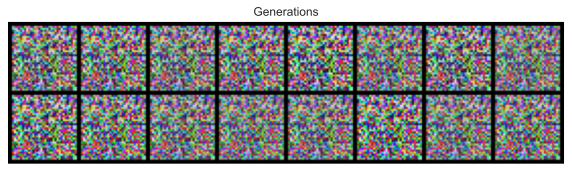

Epoch: 1, discrimiantor fake error: 0.083, discriminator real acc: 0.761
Epoch: 2, discrimiantor fake error: 0.00482, discriminator real acc: 0.879
Epoch: 3, discrimiantor fake error: 0.00333, discriminator real acc: 0.923
Epoch: 4, discrimiantor fake error: 0.00371, discriminator real acc: 0.95
Epoch: 5, discrimiantor fake error: 0.00634, discriminator real acc: 0.962
Epoch: 6, discrimiantor fake error: 0.00639, discriminator real acc: 0.97
Epoch: 7, discrimiantor fake error: 0.00376, discriminator real acc: 0.983
Epoch: 8, discrimiantor fake error: 0.00217, discriminator real acc: 0.99
Epoch: 9, discrimiantor fake error: 0.00157, discriminator real acc: 0.993
Epoch: 10, discrimiantor fake error: 0.00206, discriminator real acc: 0.994


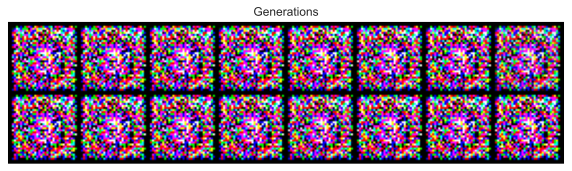

Epoch: 11, discrimiantor fake error: 0.0031, discriminator real acc: 0.993
Epoch: 12, discrimiantor fake error: 0.00672, discriminator real acc: 0.99
Epoch: 13, discrimiantor fake error: 0.00955, discriminator real acc: 0.988
Epoch: 14, discrimiantor fake error: 0.00579, discriminator real acc: 0.995
Epoch: 15, discrimiantor fake error: 0.00973, discriminator real acc: 0.988
Epoch: 16, discrimiantor fake error: 0.0195, discriminator real acc: 0.98
Epoch: 17, discrimiantor fake error: 0.0167, discriminator real acc: 0.982
Epoch: 18, discrimiantor fake error: 0.0228, discriminator real acc: 0.977
Epoch: 19, discrimiantor fake error: 0.0324, discriminator real acc: 0.967
Epoch: 20, discrimiantor fake error: 0.0284, discriminator real acc: 0.974


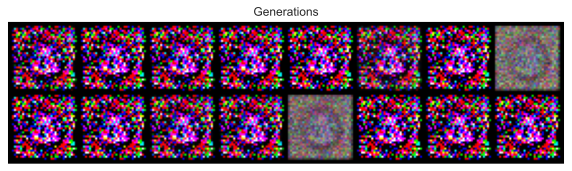

Epoch: 21, discrimiantor fake error: 0.029, discriminator real acc: 0.974
Epoch: 22, discrimiantor fake error: 0.0351, discriminator real acc: 0.967
Epoch: 23, discrimiantor fake error: 0.0293, discriminator real acc: 0.97
Epoch: 24, discrimiantor fake error: 0.0217, discriminator real acc: 0.974
Epoch: 25, discrimiantor fake error: 0.0167, discriminator real acc: 0.981
Epoch: 26, discrimiantor fake error: 0.0136, discriminator real acc: 0.985
Epoch: 27, discrimiantor fake error: 0.0298, discriminator real acc: 0.969
Epoch: 28, discrimiantor fake error: 0.0416, discriminator real acc: 0.96
Epoch: 29, discrimiantor fake error: 0.0345, discriminator real acc: 0.966
Epoch: 30, discrimiantor fake error: 0.0343, discriminator real acc: 0.965


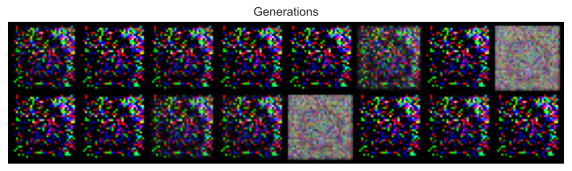

Epoch: 31, discrimiantor fake error: 0.0329, discriminator real acc: 0.968
Epoch: 32, discrimiantor fake error: 0.0317, discriminator real acc: 0.965
Epoch: 33, discrimiantor fake error: 0.0215, discriminator real acc: 0.978
Epoch: 34, discrimiantor fake error: 0.031, discriminator real acc: 0.971
Epoch: 35, discrimiantor fake error: 0.0444, discriminator real acc: 0.958
Epoch: 36, discrimiantor fake error: 0.0495, discriminator real acc: 0.954
Epoch: 37, discrimiantor fake error: 0.054, discriminator real acc: 0.941
Epoch: 38, discrimiantor fake error: 0.0415, discriminator real acc: 0.954
Epoch: 39, discrimiantor fake error: 0.031, discriminator real acc: 0.965
Epoch: 40, discrimiantor fake error: 0.0405, discriminator real acc: 0.961


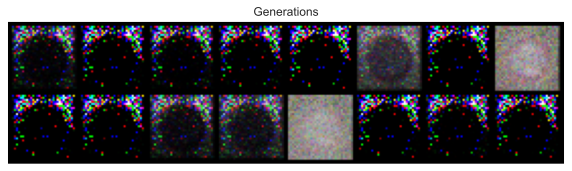

Epoch: 41, discrimiantor fake error: 0.0565, discriminator real acc: 0.946
Epoch: 42, discrimiantor fake error: 0.0633, discriminator real acc: 0.939
Epoch: 43, discrimiantor fake error: 0.0659, discriminator real acc: 0.936
Epoch: 44, discrimiantor fake error: 0.0638, discriminator real acc: 0.939
Epoch: 45, discrimiantor fake error: 0.0714, discriminator real acc: 0.926
Epoch: 46, discrimiantor fake error: 0.0677, discriminator real acc: 0.931
Epoch: 47, discrimiantor fake error: 0.0709, discriminator real acc: 0.929
Epoch: 48, discrimiantor fake error: 0.0781, discriminator real acc: 0.924
Epoch: 49, discrimiantor fake error: 0.0823, discriminator real acc: 0.924
Epoch: 50, discrimiantor fake error: 0.0888, discriminator real acc: 0.916


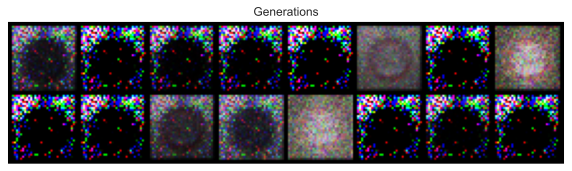

Epoch: 51, discrimiantor fake error: 0.0917, discriminator real acc: 0.909
Epoch: 52, discrimiantor fake error: 0.0823, discriminator real acc: 0.919
Epoch: 53, discrimiantor fake error: 0.0752, discriminator real acc: 0.926
Epoch: 54, discrimiantor fake error: 0.0616, discriminator real acc: 0.936
Epoch: 55, discrimiantor fake error: 0.0595, discriminator real acc: 0.939
Epoch: 56, discrimiantor fake error: 0.0749, discriminator real acc: 0.925
Epoch: 57, discrimiantor fake error: 0.0867, discriminator real acc: 0.911
Epoch: 58, discrimiantor fake error: 0.0821, discriminator real acc: 0.919
Epoch: 59, discrimiantor fake error: 0.0865, discriminator real acc: 0.923
Epoch: 60, discrimiantor fake error: 0.0751, discriminator real acc: 0.922


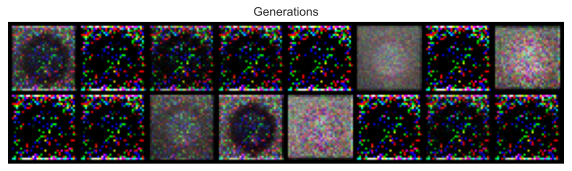

Epoch: 61, discrimiantor fake error: 0.0757, discriminator real acc: 0.919
Epoch: 62, discrimiantor fake error: 0.0647, discriminator real acc: 0.931
Epoch: 63, discrimiantor fake error: 0.0723, discriminator real acc: 0.934
Epoch: 64, discrimiantor fake error: 0.0844, discriminator real acc: 0.919
Epoch: 65, discrimiantor fake error: 0.0908, discriminator real acc: 0.914
Epoch: 66, discrimiantor fake error: 0.101, discriminator real acc: 0.903
Epoch: 67, discrimiantor fake error: 0.102, discriminator real acc: 0.901
Epoch: 68, discrimiantor fake error: 0.1, discriminator real acc: 0.905
Epoch: 69, discrimiantor fake error: 0.0851, discriminator real acc: 0.908
Epoch: 70, discrimiantor fake error: 0.0857, discriminator real acc: 0.915


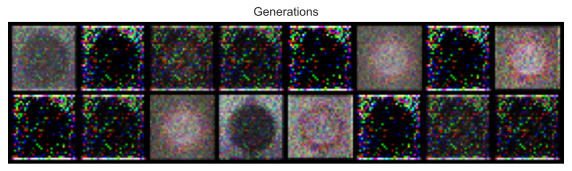

Epoch: 71, discrimiantor fake error: 0.079, discriminator real acc: 0.916
Epoch: 72, discrimiantor fake error: 0.0767, discriminator real acc: 0.93
Epoch: 73, discrimiantor fake error: 0.0873, discriminator real acc: 0.914
Epoch: 74, discrimiantor fake error: 0.086, discriminator real acc: 0.915
Epoch: 75, discrimiantor fake error: 0.0806, discriminator real acc: 0.929
Epoch: 76, discrimiantor fake error: 0.0893, discriminator real acc: 0.914
Epoch: 77, discrimiantor fake error: 0.0935, discriminator real acc: 0.906
Epoch: 78, discrimiantor fake error: 0.0794, discriminator real acc: 0.918
Epoch: 79, discrimiantor fake error: 0.0834, discriminator real acc: 0.914
Epoch: 80, discrimiantor fake error: 0.0877, discriminator real acc: 0.911


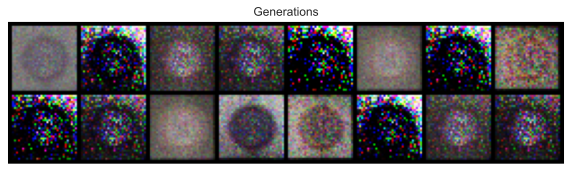

Epoch: 81, discrimiantor fake error: 0.0863, discriminator real acc: 0.909
Epoch: 82, discrimiantor fake error: 0.088, discriminator real acc: 0.919
Epoch: 83, discrimiantor fake error: 0.0874, discriminator real acc: 0.912
Epoch: 84, discrimiantor fake error: 0.0874, discriminator real acc: 0.913
Epoch: 85, discrimiantor fake error: 0.0969, discriminator real acc: 0.91
Epoch: 86, discrimiantor fake error: 0.0936, discriminator real acc: 0.911
Epoch: 87, discrimiantor fake error: 0.0992, discriminator real acc: 0.899
Epoch: 88, discrimiantor fake error: 0.117, discriminator real acc: 0.887
Epoch: 89, discrimiantor fake error: 0.106, discriminator real acc: 0.896
Epoch: 90, discrimiantor fake error: 0.113, discriminator real acc: 0.891


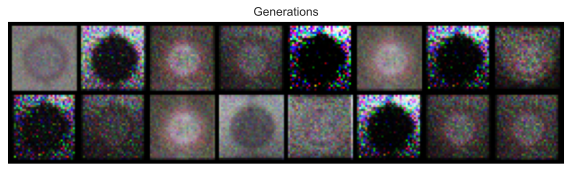

Epoch: 91, discrimiantor fake error: 0.111, discriminator real acc: 0.895
Epoch: 92, discrimiantor fake error: 0.116, discriminator real acc: 0.884
Epoch: 93, discrimiantor fake error: 0.109, discriminator real acc: 0.887
Epoch: 94, discrimiantor fake error: 0.0973, discriminator real acc: 0.904
Epoch: 95, discrimiantor fake error: 0.103, discriminator real acc: 0.899
Epoch: 96, discrimiantor fake error: 0.0996, discriminator real acc: 0.91
Epoch: 97, discrimiantor fake error: 0.108, discriminator real acc: 0.89
Epoch: 98, discrimiantor fake error: 0.131, discriminator real acc: 0.878
Epoch: 99, discrimiantor fake error: 0.133, discriminator real acc: 0.887


In [61]:
G_losses = []
D_losses = []
num_epochs = 100
for epoch in range(num_epochs):
    # For each batch in the dataloader
    discriminator_fake_acc = []
    discriminator_real_acc = []
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator_optimizer.zero_grad()
        # Format batch
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.ones((b_size,), dtype=torch.float, device=device) # Setting labels for real images
        # Forward pass real batch through D
        output = discriminator(real_images).view(-1)
        # Calculate loss on all-real batch
        error_discriminator_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        error_discriminator_real.backward()
        discriminator_real_acc.append(output.mean().item())

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_dim,device=device)
        # Generate fake image batch with Generator
        fake_images = generator(noise)
        label_fake = torch.zeros((b_size,), dtype=torch.float, device=device)
        # Classify all fake batch with Discriminator
        output = discriminator(fake_images.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        error_discriminator_fake = criterion(output, label_fake)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        error_discriminator_fake.backward()
        discriminator_fake_acc.append(output.mean().item())
        # Compute error of D as sum over the fake and the real batches
        error_discriminator = error_discriminator_real + error_discriminator_fake
        # Update D
        discriminator_optimizer.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator_optimizer.zero_grad()
        label = torch.ones((b_size,), dtype=torch.float, device=device)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake_images).view(-1)
        # Calculate G's loss based on this output
        error_generator = criterion(output, label)
        # Calculate gradients for G
        error_generator.backward()
        D_G_z2 = output.mean().item()
        # Update G
        generator_optimizer.step()

        # Output training stats
        # Save Losses for plotting later
        G_losses.append(error_generator.item())
        D_losses.append(error_discriminator.item())

    print(f"Epoch: {epoch}, discrimiantor fake error: {np.mean(discriminator_fake_acc):.3}, discriminator real acc: {np.mean(discriminator_real_acc):.3}")
    generator_scheduler.step()
    discriminator_scheduler.step()
    if epoch % 10 == 0:
        with torch.no_grad():
            fake = generator(fixed_noise).detach().cpu()
        grid = torchvision.utils.make_grid(fake)
        grid = grid.permute(1, 2, 0)
        plt.figure(figsize=(10,10))
        plt.title(f"Generations")
        plt.imshow(grid)
        plt.axis('off')
        plt.show()

## Check with generator

In [62]:
class Cond_Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Cond_Discriminator, self).__init__()

        self.fc_1 = nn.Linear(input_dim + 10, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out  = nn.Linear(hidden_dim, 1)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x, y):
        x = torch.flatten(x, 1)
        x = torch.cat([x,y], 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        x = self.fc_out(x)
        return x

In [63]:
class Cond_Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Cond_Generator, self).__init__()
        self.fc_1 = nn.Linear(latent_dim+10, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x,y):
        x = torch.cat([x,y], 1)
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))
        x_hat = torch.sigmoid(self.fc_3(h))
        # x_hat = x_hat.view([-1, 1, 28, 28])
        x_hat = x_hat.view([-1, 3, 32, 32])
        return x_hat

In [65]:
# Models
latent_dim = 128
cond_generator = Cond_Generator(latent_dim=latent_dim, hidden_dim=1024, output_dim=3072).to(device)
cond_discriminator = Cond_Discriminator( hidden_dim=1024, input_dim=3072).to(device)

# Optimizers
generator_optimizer = torch.optim.Adam(cond_generator.parameters(), lr=0.0001)
generator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=0.99)
discriminator_optimizer = torch.optim.Adam(cond_discriminator.parameters(), lr=0.0001)
discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)

# loss
criterion = nn.MSELoss()

In [66]:
import torch.nn.functional as F

fixed_noise = torch.randn(16, latent_dim,device=device)
fixed_labels = torch.randint(10,(16,),device=device)
fixed_labels = F.one_hot(fixed_labels, 10).float()

In [67]:
G_losses = []
D_losses = []
num_epochs = 101
for epoch in range(num_epochs):
    # For each batch in the dataloader
    discriminator_fake_acc = []
    discriminator_real_acc = []
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator_optimizer.zero_grad()
        # Format batch
        real_images = data[0].to(device)
        y = data[1]
        y = F.one_hot(y).to(device).float()
        b_size = real_images.size(0)

        # print(b_size)

        label = torch.ones((b_size,), dtype=torch.float, device=device) # Setting labels for real images
        # Forward pass real batch through D
        output = cond_discriminator(real_images, y).view(-1)
        # Calculate loss on all-real batch
        error_discriminator_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        error_discriminator_real.backward()
        discriminator_real_acc.append(output.mean().item())

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_dim,device=device)
        rand_y = torch.randint(10,(b_size,),device=device)
        rand_y = F.one_hot(rand_y, 10).float()
        # Generate fake image batch with Generator
        fake_images = cond_generator(noise, rand_y)
        label_fake = torch.zeros((b_size,), dtype=torch.float, device=device)
        # Classify all fake batch with Discriminator
        output = cond_discriminator(fake_images.detach(), rand_y).view(-1)
        # Calculate D's loss on the all-fake batch
        error_discriminator_fake = criterion(output, label_fake)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        error_discriminator_fake.backward()
        discriminator_fake_acc.append(output.mean().item())
        # Compute error of D as sum over the fake and the real batches
        error_discriminator = error_discriminator_real + error_discriminator_fake
        # Update D
        discriminator_optimizer.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
#         for _ in range(3):
        noise = torch.randn(b_size, latent_dim,device=device)
        rand_y = torch.randint(10,(b_size,),device=device)
        rand_y = F.one_hot(rand_y, 10).float()
        fake_images = cond_generator(noise, rand_y)
        generator_optimizer.zero_grad()
        label = torch.ones((b_size,), dtype=torch.float, device=device)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = cond_discriminator(fake_images, rand_y).view(-1)
        # Calculate G's loss based on this output
        error_generator = criterion(output, label)
        # Calculate gradients for G
        error_generator.backward()
        D_G_z2 = output.mean().item()
        # Update G
        generator_optimizer.step()

        # Output training stats
        # Save Losses for plotting later
        G_losses.append(error_generator.item())
        D_losses.append(error_discriminator.item())

    print(f"Epoch: {epoch}, discrimiantor fake error: {np.mean(discriminator_fake_acc):.3}, discriminator real acc: {np.mean(discriminator_real_acc):.3}")
    generator_scheduler.step()
    discriminator_scheduler.step()
    if epoch % 10 == 0:
        with torch.no_grad():
            fake = cond_generator(fixed_noise, fixed_labels).detach().cpu()
        grid = torchvision.utils.make_grid(fake)
        grid = grid.permute(1, 2, 0)
        plt.figure(figsize=(10,10))
        plt.title(f"Generations")
        plt.imshow(grid)
        plt.axis('off')
        plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (256x3115 and 3082x1024)